This notebook is the tester for developing a system for recording models in a simplistic method

In [377]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


model_vgg16 = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

model_vgg16_imagenet = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


model_vgg16_test = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

model_resnet50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=500,
    classifier_activation="softmax",
)


model_resnet50_imagenet = tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",
)

In [227]:
# From https://stackoverflow.com/questions/13530762/how-to-know-bytes-size-of-python-object-like-arrays-and-dictionaries-the-simp

import gc
import sys

def get_obj_size(obj):
    marked = {id(obj)}
    obj_q = [obj]
    sz = 0

    while obj_q:
        sz += sum(map(sys.getsizeof, obj_q))

        # Lookup all the object referred to by the object in obj_q.
        # See: https://docs.python.org/3.7/library/gc.html#gc.get_referents
        all_refr = ((id(o), o) for o in gc.get_referents(*obj_q))

        # Filter object that are already marked.
        # Using dict notation will prevent repeated objects.
        new_refr = {o_id: o for o_id, o in all_refr if o_id not in marked and not isinstance(o, type)}

        # The new obj_q will be the ones that were not marked,
        # and we will update marked with their ids so we will
        # not traverse them again.
        obj_q = new_refr.values()
        marked.update(new_refr.keys())

    return sz

import sys
   
print(get_obj_size(model_vgg16))

print(get_obj_size(model_resnet50))
print(get_obj_size(model_resnet50_imagenet))



157474351
157474327
157481324


In [228]:
for l1, l2 in zip(model_vgg16.layers, model_resnet50.layers):
    conf1 = l1.get_config()
    conf2 = l2.get_config()

    if ('batch_input_shape' in conf1) or ('units' in conf1):
        print(conf1 == conf2)
        print(conf1['name'])


False
input_24
False
fc1
False
fc2
False
predictions


In [229]:
layer = model_vgg16.layers[1]

layer_data  = (
    layer.__class__.__name__,
    layer.input_shape,
    layer.output_shape,
    layer.trainable,
    layer.count_params()
)
print(layer_data)


('Conv2D', (None, 224, 224, 3), (None, 224, 224, 64), True, 1792)


In [230]:
import hashlib
from scipy.stats import skew

In [231]:


def create_layer_data(layer):

    # get structure array
    layer_structure  = {
        "class": layer.__class__.__name__,
        "input_shape": layer.input_shape,
        "output_shape": layer.output_shape,
        "trainable": layer.trainable,
        "params": layer.count_params(),
        "name": layer.name
    }

    # get layer weights and bias
    weights = layer.get_weights()
    if len(weights) == 1:
        weight_x = np.ndarray.flatten(weights[0])
        bias_x = np.array([])
        skew_x = skew(np.ndarray.flatten(weights[0]))

    if len(weights) > 1:
        weight_x = np.ndarray.flatten(weights[0])
        bias_x = np.ndarray.flatten(weights[1])
        skew_x = skew(np.ndarray.flatten(weights[0]))

    else:
        weight_x = np.array([0])
        bias_x = np.array([0])
        skew_x = 0

    layer_values = {
        "weight_std" : np.std(weight_x).item(),
        "weight_mean" : np.mean(weight_x).item(),
        "bias_std" : np.std(bias_x).item(),
        "bias_mean" : np.mean(bias_x).item(),
        "skew" : skew_x
    }

    return layer_structure, layer_values

def create_model_data(model):
    # initiate hashing function
    sha = hashlib.sha256()

    layer_data_set = {}
    layer_structure_set = {}
    
    for index, value in enumerate(model.layers):
        # Run through the layers
        layer_structure, layer_data = create_layer_data(value)
        # print(layer_data, layer_values, hash(layer_values))
        sha.update(repr(layer_structure).encode('utf-8'))
        sha.update(repr(layer_data).encode('utf-8'))

        layer_data_set[str(index)] = layer_data
        layer_structure_set[str(index)] = layer_structure

    
    layer_data = {"structure":layer_structure_set, "data":layer_data_set}
#    sha.update(repr(layer_data).encode('utf-8'))

    return sha.hexdigest(), layer_data




#     sha.update(repr(layer_data).encode('utf-8'))


In [233]:

signature1, layer_data1 = create_model_data(model_vgg16)
print(signature1)
signature2, layer_data2 = create_model_data(model_vgg16_test)
print(signature2)

# 5334e90eb169d941ae8c699abb32f0999d44ea058e221dd207f568a68c65835b
# 5030bac61995e80abd7377ac917fa7ca81378245203fa3ae4dce2c4a5804cf4d

f59bec808340052cb5065878c815d1d46d2826b61cd907d9c6ab1ca159665750
e0c0e5bce1e5a7dc9323e09a24ca4acf2d2d7237e8298986cec71f44a2430b53


In [211]:
# setup global write variables
bb_username = 'brendan.bonner@mail.dcu.ie'
bb_organisation = 'DCU'
bb_model_source = 'created in python'

In [315]:
import pymongo
from bson.objectid import ObjectId

def init_model_db():
    global db_col_data
    global db_col_signature


    dbclient = pymongo.MongoClient("mongodb://localhost:27017/")
    dbclient_database = dbclient["model_database"]
    db_col_data = dbclient_database["modeldata"]
    db_col_signature = dbclient_database["signature"]


    # Make sure signatures are unique on both
    db_col_signature.create_index(
        [("signature", pymongo.DESCENDING)],
        unique=True
    )


    remote_client = MongoClient('mongodb+srv://cluster0.7ilyj.mongodb.net/myFirstDatabase')
    dbclient_database_r = remote_client["model_database"]
    db_col_data_r = dbclient_database_r["modeldata"]
    db_col_signature_r = dbclient_database_r["signature"]
    
    
    remote_user = False
    if(remote_user):
        # Only if there is a remote account, allow writing, otherwise read only
        db_col_signature_r.create_index(
            [("signature", pymongo.DESCENDING)],
            unique=True
        )


def write_model_db(
    signature,
    model_data,
    username = bb_username,
    organisation = bb_organisation,
    model_source=bb_model_source,
    parent = '',
    local=True):

    if (local):
        db_data = db_col_data
        db_sig = db_col_signature
    else:
        db_data = db_col_data_r
        db_sig = db_col_signature_r

    # Insert Signature to Database (signatures)
    if get_model(signature) == None:
        x = db_col_data.insert_one(model_data)
        model_id = x.inserted_id
        # print(model_id, 'for sig: ', signature)

        # Inset Model Data to Database (modeldata)
        signature_data =  {
            'signature': signature,
            'parent': parent,
            'username': username,
            'organisation':organisation,
            'model_source': model_source,
            'model_data': model_id
        }

        x = db_col_signature.insert_one(signature_data)
        signature_model_id = x.inserted_id
        return signature_model_id
    else:
        print('signature: ', signature, ' already in database')
        return None


def push_model(model, local=True, parent=None, username=bb_username, organisation = bb_organisation):
    signature, layer_data = create_model_data(model)

    write_model_db(
        signature=signature,
        model_data=layer_data,
        parent=parent,
        username=username,
        organisation=organisation,
        local=local
    )
    return signature



def get_model(signature):
    signature_data = db_col_signature.find_one({'signature': signature})
    if(signature_data):
        return signature_data
    else:
        return None


# The web framework gets post_id from the URL and passes it as a string
def get_model_data(model_id):
    document = db_col_data.find_one({'_id': ObjectId(model_id)})
    return document


In [316]:
#initialise model database
init_model_db()

In [317]:
# get a signature and write it to the model


parent = push_model(model_resnet50)
last = push_model(model_resnet50_imagenet,parent=parent)
parent = push_model(model_vgg16)
last = push_model(model_vgg16_test, parent=parent)


signature:  3fb925563160909dbe1a0e46fe2ab86b5ffae097938687c0527a1a2d79602299  already in database
signature:  071a8536a9a01f58cefab7281f075aa99738392932a85b85ed936b30dc875c5d  already in database
signature:  f59bec808340052cb5065878c815d1d46d2826b61cd907d9c6ab1ca159665750  already in database
signature:  fefd9fe33486456cfa94b9d0f188e394d41b38577b052e09f0082c366369192e  already in database


"\nsignature, layer_data = create_model_data(model_vgg16)\nlast_signature = write_model_db(\n    signature=signature,\n    model_data=layer_data,\n    model_source='https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py'\n)\n\n\nsignature, layer_data = create_model_data(model_vgg16_test)\nnew_signature = write_model_db(\n    signature=signature,\n    model_data=layer_data,\n    parent = last_signature\n)\n"

In [281]:
# Make a small adjustment to test the SHA change


for x in range(5):
    weights = model_vgg16_test.layers[1].get_weights()
    weights[0][0][0][0] = weights[0][0][0][0] * 1.004
    model_vgg16_test.layers[1].set_weights(weights)
    last = push_model(model_vgg16_test, parent=last, username='brendanboner@gmail.com')
    print(last)


53af1f4959137db767ba817f3e74d899431badfe02a0ddeb0ed67c7ba6d32481
331ebee95ee365303ddb855d2f11fe216dcac08f7e31222d8281bf960e4e8b90
d08398ab16003cd3da407c6c0069fb6e7ebc6f1e8fba86e494e67a5df659f5b3
83b75799aacffa45eed32af1f71373223a24d6d4c2c5eb9a6250f9e5b9fdfe57
fefd9fe33486456cfa94b9d0f188e394d41b38577b052e09f0082c366369192e


In [367]:
# Get model and write to layer

def show_history(signature):

    print("Getting Signature: ",signature)
    signature_data = get_model(signature)
    baseline_model_data = get_model_data(signature_data['model_data'])

    if baseline_model_data == None:
        print ('no model data for : ', signature_data['model_data'])
    else:
        print('Layers: ', len(baseline_model_data['data']))
        print( signature_data['_id'].generation_time, ' : Model Id ', signature_data['model_data'])
        old_data = baseline_model_data['data']

        history = []
        while signature_data['parent'] != None:

            # get model
            signature_data = get_model(signature_data['parent'])
            print( signature_data['_id'].generation_time, ' : Model Id ', signature_data['model_data'])

            new_model_data = get_model_data(signature_data['model_data'])
            if new_model_data == None:
                print ('no model data for : ', signature_data['model_data'])
            else:
                history_layer = []
                data = new_model_data['data']
                for key, value in data.items():
                    if (old_data[key]['weight_std'] == 0):
                        history_layer.append(old_data[key]['weight_std'])
                    else:
                        history_layer.append(
                            value['weight_std']  / old_data[key]['weight_std'],
                        )

                history.append(history_layer)
                old_data = new_model_data['data']


 

        print(signature_data['username'], signature_data['organisation'])
        print(history[0])


show_history('5c6b29d372e51b3a95c245d851322f0b3b8387a02fbb6b680e3ccd48fdba7f45') # trained VGG16

# show_history('071a8536a9a01f58cefab7281f075aa99738392932a85b85ed936b30dc875c5d') # ResNet50 

Getting Signature:  5c6b29d372e51b3a95c245d851322f0b3b8387a02fbb6b680e3ccd48fdba7f45
Layers:  23
2021-08-02 21:51:50+00:00  : Model Id  610868f69f6c9bb4ee1ce411
2021-08-02 21:51:47+00:00  : Model Id  610868f39f6c9bb4ee1ce40f
2021-08-02 21:51:43+00:00  : Model Id  610868ef9f6c9bb4ee1ce40d
2021-08-02 21:51:40+00:00  : Model Id  610868ec9f6c9bb4ee1ce40b
2021-08-02 21:50:31+00:00  : Model Id  610868a79f6c9bb4ee1ce409
2021-08-02 21:50:25+00:00  : Model Id  610868a19f6c9bb4ee1ce407
2021-08-02 21:49:41+00:00  : Model Id  610868759f6c9bb4ee1ce405
2021-08-02 21:46:32+00:00  : Model Id  610867b89f6c9bb4ee1ce403
2021-08-02 21:46:26+00:00  : Model Id  610867b29f6c9bb4ee1ce401
brendan.bonner@mail.dcu.ie DCU
[0.0, 0.9999393971930307, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]


In [6]:
def diff_model(model_vgg16, model_resnet50):
    for l1, l2 in zip(model_vgg16.layers, model_resnet50.layers):
        w1 = l1.get_weights()
        w2 = l2.get_weights()
        if len(w1) > 0:
            wa1 = np.ndarray.flatten(w1[0])
            wa2 = np.ndarray.flatten(w2[0])
            # Weights available
            print(l1.get_config()['name'],
                w1[0].shape,
                np.std(wa1), np.median(wa1),
                w2[0].shape,
                np.std(wa2), np.median(wa2),
                np.std(wa1) == np.std(wa2)
            )
            
        else:
            print(l1.get_config()['name'],len(w1))

In [ ]:
print(layer_data['structure'])

In [8]:
 # Database functions

import pymongo
import datetime

from pymongo import MongoClient

client = MongoClient('mongodb+srv://cluster0.7ilyj.mongodb.net/myFirstDatabase')


In [81]:
db = client.model
db.model.list_indexes()

input_33 0
std 0.0583, skew -0.0330
std 0.2067, skew -0.0145
block1_conv1 2 (3, 3, 3, 64)


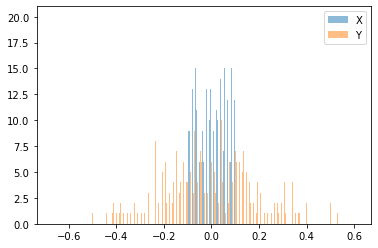

std 0.0417, skew -0.0045
std 0.0425, skew 0.9093
block1_conv2 2 (3, 3, 64, 64)


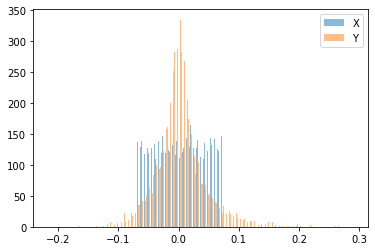

block1_pool 0
std 0.0339, skew -0.0074
std 0.0322, skew 0.1505
block2_conv1 2 (3, 3, 64, 128)


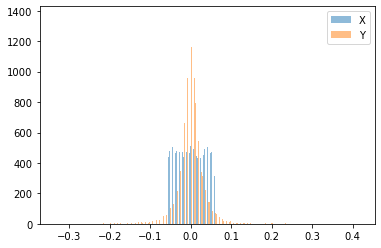

std 0.0295, skew -0.0051
std 0.0235, skew 0.3855
block2_conv2 2 (3, 3, 128, 128)


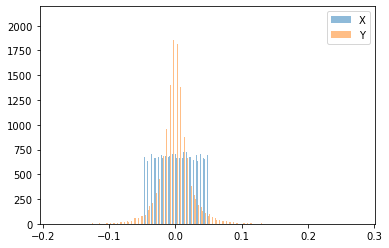

block2_pool 0
std 0.0241, skew -0.0033
std 0.0174, skew 0.6235
block3_conv1 2 (3, 3, 128, 256)


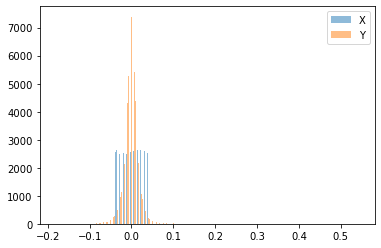

std 0.0208, skew -0.0021
std 0.0123, skew 0.7575
block3_conv2 2 (3, 3, 256, 256)


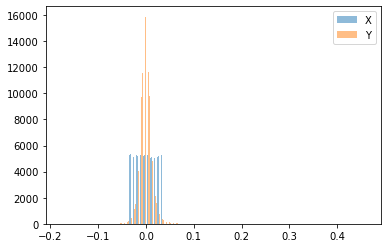

std 0.0209, skew 0.0007
std 0.0127, skew 1.0946
block3_conv3 2 (3, 3, 256, 256)


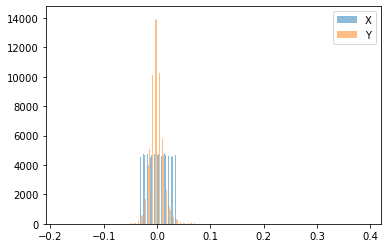

block3_pool 0
std 0.0170, skew 0.0000
std 0.0101, skew 0.6153
block4_conv1 2 (3, 3, 256, 512)


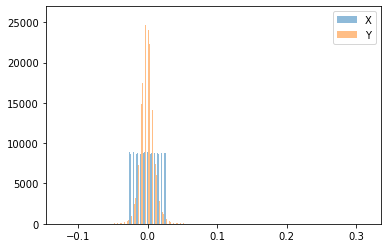

std 0.0147, skew -0.0001
std 0.0076, skew 0.5342
block4_conv2 2 (3, 3, 512, 512)


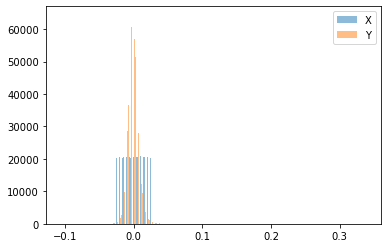

std 0.0147, skew -0.0003
std 0.0080, skew 0.7202
block4_conv3 2 (3, 3, 512, 512)


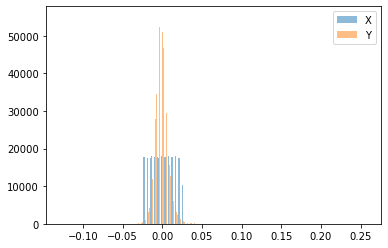

block4_pool 0
std 0.0147, skew -0.0018
std 0.0087, skew 0.5710
block5_conv1 2 (3, 3, 512, 512)


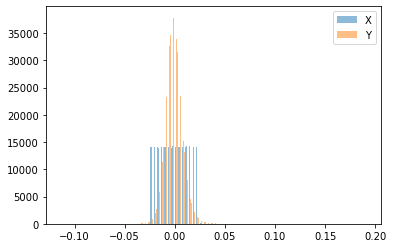

std 0.0147, skew 0.0002
std 0.0088, skew 0.4924
block5_conv2 2 (3, 3, 512, 512)


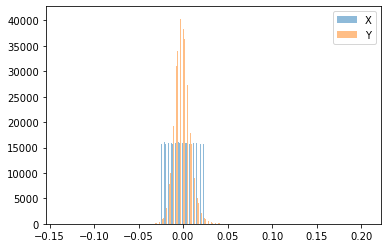

std 0.0147, skew 0.0008
std 0.0085, skew 0.6390
block5_conv3 2 (3, 3, 512, 512)


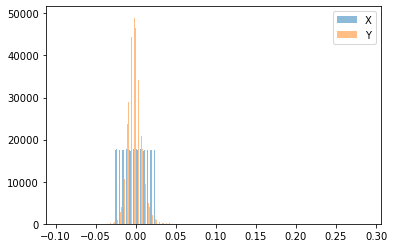

block5_pool 0
flatten 0
std 0.0083, skew -0.0003
std 0.0023, skew 0.2392
fc1 2 (25088, 4096)


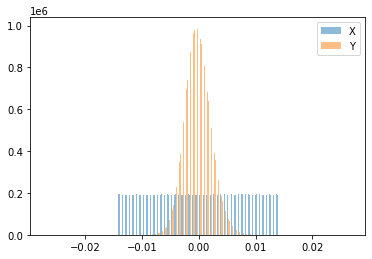

std 0.0156, skew 0.0003
std 0.0044, skew 0.1923
fc2 2 (4096, 4096)


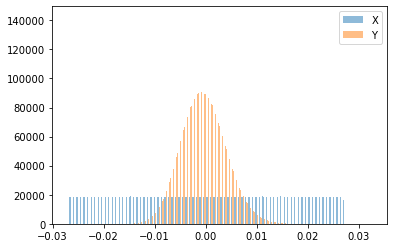

std 0.0198, skew -0.0000
std 0.0083, skew 0.4478
predictions 2 (4096, 1000)


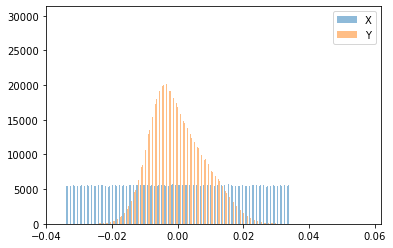

In [378]:
#Display a comparison of multiple layers
def get_weights_print_stats(layer):
    W = layer.get_weights()
    if len(W) > 0:
        print(len(W))
        print(W[0].shape)
    return W

def hist_weights(weights, bins=100, label='default'):
    for weight in weights:
        
        plt.hist(np.ndarray.flatten(weight), bins=bins, label=label)

'''
for l1, l2 in zip(model_vgg16.layers, model_resnet50.layers):
    print(l1.get_config()['name'])
    W = get_weights_print_stats(l1)
    hist_weights(W, label='Model 1')
    W = get_weights_print_stats(l2)
    hist_weights(W, label='Model 2')
    plt.show()
'''
for l1, l2 in zip(model_vgg16.layers, model_vgg16_imagenet.layers):

    w1 = l1.get_weights()
    w2 = l2.get_weights()

    if len(w1) > 0:
        # Layers available

        weight1_value   = np.ndarray.flatten(w1[0])
        weight1_skew  = skew(np.ndarray.flatten(w1[0]))
        weight1_std     = np.std(weight1_value).item()
        print('std {:.4f}, skew {:.4f}'.format(weight1_std, weight1_skew))
        
        weight2_value   = np.ndarray.flatten(w2[0])
        weight2_skew  = skew(np.ndarray.flatten(w2[0]))
        weight2_std     = np.std(weight2_value).item()
        print('std {:.4f}, skew {:.4f}'.format(weight2_std, weight2_skew))
        
        print(l1.get_config()['name'],len(w1), w1[0].shape)
        plt.hist(
            [ np.ndarray.flatten(w1[0]),
            np.ndarray.flatten(w2[0])],
            alpha=0.5, bins=1000, label=['X','Y'])
        plt.legend(loc='upper right')

        plt.show()

    else:
        print(l1.get_config()['name'],len(w1))
    